# Become a data driven Airbnb host 2

This is a blog continued from the first one: . In this blog, we try to solve a business problem through machine learning --- predicting future earnings based on the current listing information. Imagine that you are an Airbnb host and you would like to know the expected earning for one of your listings next year. Once you have the model, you can play with the information of your listing to see how you might change your future earning if there's any variations of your current listing. 

# 1. Load data and packages

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from datetime import date
import sklearn
from sklearn.preprocessing import Imputer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
pd.set_option("display.max_columns", 100)
pd.set_option('max_colwidth',200)

In [7]:
calendar = pd.read_csv("calendar.csv")
listings = pd.read_csv("listings.csv")
reviews = pd.read_csv("reviews.csv")

# 2. Investigate rows with high missing rates

First, let's check if there are special groups of listings with a lot of N/A columns ---- maybe they are very new or bad listings which we want to leave out when building our model.

Text(0.5, 1.0, 'Missing rates (rows)')

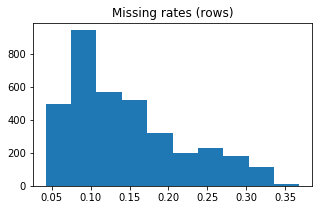

In [8]:
# How much data is missing in each row of the dataset?
missing_values_in_rows = listings.isna().mean(axis=1).values
plt.rcParams['figure.figsize'] = (5, 3)
ax = plt.hist(missing_values_in_rows)
plt.title('Missing rates (rows)')

A bad senario will be that there's a group of rows with significantly higher missing rates. In our case, it's good to see that most of the listings have at least 70% of the fields flled, and the shape of the distribution is kind of ideal.

# 3. Feature engineering

We then create features from the existing columns. Once this is done, we will add some columns in the raw data that we can directly use without much engineering. The features we generated:
1. downtown_bos, east_bos: whether the listing is in one of the two neighborhoods. From the exploration, many of the listings are from these areas, maybe they are convenient/go-to areas in Boston.
2. host_age: generated from host_since (months)
3. reponse_rate, acceptance_rate: convert to numbers
4. one_or_two_listings, three_to_ten_listings, more_than_ten_listings: how many listings the host has
5. response_time_ordinal： generated from response_time
6. real_bed: if the bed is a real bed
7. neighborhoods_one_hot: one-hot coding to indicate if the listing is in one of 10 most popular neighborhoods
8. amenities_len: length of the amenities field to roughly indicate how many amenities the listing offers
9. cancellation_policy_ordinal: the larger the number the more flexible the cancellation policy is
10. price_per_bed_compared_to_nbh: the difference between the price per bed for that listing and the average price per bed for that neighborhood (**this is a slightly complicated feature to build! We will do it in the end**)

## 3.1 Generated features

In [9]:
def lower(s):
    try:
        return s.lower()
    except:
        return s

def perc_to_numbers(p):
    '''
    "30%" --> 0.3
    '''
    try:
        return float(p.split("%")[0])/100
    except:
        return float("nan")

In [11]:
summary = listings['summary'].apply(lower)
downtown_bos = summary.str.contains("downtown boston").astype("float32")
east_bos = summary.str.contains("east boston").astype("float32")
host_age = listings['host_since'].apply(lambda x: (datetime.datetime.today() - pd.to_datetime(x)).days/30)
reponse_rate = listings['host_response_rate'].apply(perc_to_numbers)
acceptance_rate = listings['host_acceptance_rate'].apply(perc_to_numbers)

A small investigation on the numbers of listings:

In [12]:
listings[['host_total_listings_count']].describe()

,host_total_listings_count
count,3585.000000
mean,58.902371
std,171.119663
min,0.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,749.000000


In [27]:
print("{:.2%} of the hosts have no more than 2 listings, {:.2%} of the hosts have more than 10 listings"\
.format(sum(listings['host_total_listings_count']<=2)/len(listings), sum(listings['host_total_listings_count']>10)/len(listings)))

59.02% of the hosts have no more than 2 listings, 22.45% of the hosts have more than 10 listings


Hosts with one or two listings might just have two rooms for rent in one apartment/house. We will group them together. 40% of the hosts have multiple properties and some of them even have hundred of listings. We thus create the groups:
- hosts with 1~2 listings
- hosts with 3~10 listings
- hosts with more than 10 listings

In [30]:
one_or_two_listings = listings['host_total_listings_count'] <= 2 
three_to_ten_listings = (listings['host_total_listings_count'] > 2) & (listings['host_total_listings_count'] < 10)
more_than_ten_listings = listings['host_total_listings_count'] > 10

In [32]:
response_time_dict = {
    'a few days or more':1,
    'within a day': 2,
    'within a few hours': 3,
    'within an hour': 4
}

Some records have `N/A` response time. Are they very new listings?

(array([ 63., 100.,  95.,  74.,  41.,  33.,  28.,  18.,   9.,  10.]),
 array([ 37.46666667,  45.16666667,  52.86666667,  60.56666667,
         68.26666667,  75.96666667,  83.66666667,  91.36666667,
         99.06666667, 106.76666667, 114.46666667]),
 <a list of 10 Patch objects>)

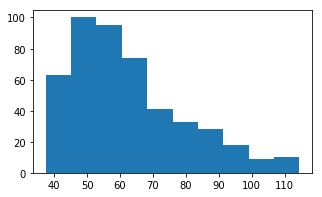

In [33]:
plt.hist(host_age[listings['host_response_time'].isna()])

The distribution of host_age for these listings is consistent with the distribution for all the listings. So we fill the nan values with `"within a few hours"` (the 2nd popular value for this column; We didn't choose to fill with `within an hour` to avoid overestimating the field. We believe that most hosts can reply within a few hours).

In [35]:
response_time_ordinal = listings['host_response_time']\
                        .fillna("within a few hours").apply(lambda x: response_time_dict[x])

In [38]:
real_bed = listings['bed_type'] == "Real Bed"
popular_neighborhoods = list(listings\
                        .groupby('neighbourhood_cleansed')\
                        .count()['id'].sort_values(ascending=False)[:10].index)
neighborhoods_one_hot = pd.get_dummies(listings[['neighbourhood_cleansed']])
amenities_len = listings['amenities'].apply(len)
cancellation_policy_dict = {
    'flexible': 1,
    'moderate': 2,
    'strict': 3,
    'super_strict_30': 4
}
cancellation_policy_ordinal = listings['cancellation_policy']\
                              .fillna("super_strict_30").apply(lambda x: cancellation_policy_dict[x])

In [39]:
final_df = pd.DataFrame({
    'id': listings['id'],
    'downtown_bos': downtown_bos,
    'east_bos': east_bos,
    'host_age': host_age,
    'reponse_rate': reponse_rate,
    'acceptance_rate': acceptance_rate,
    'one_or_two_listings': one_or_two_listings,
    'three_to_ten_listings': three_to_ten_listings,
    'more_than_ten_listings': more_than_ten_listings,
    'response_time_ordinal': response_time_ordinal,
    'real_bed': real_bed,
    'amenities_len': amenities_len,
    'cancellation_policy_ordinal': cancellation_policy_ordinal
}).join(neighborhoods_one_hot)

## 3.2. Binary columns

In [40]:
def convert_binary(x):
    try:
        return 1 if x == "t" else 0
    except:
        return 0

In [41]:
binary_pd = listings[['host_is_superhost',
              'host_has_profile_pic',
              'host_identity_verified',
              'is_location_exact',
              'requires_license',
              'instant_bookable',
              'require_guest_profile_picture',
              'require_guest_phone_verification']].applymap(convert_binary)

In [42]:
final_df = final_df.join(binary_pd)

## 3.3 Convert money value strings to numbers

In [43]:
def convert_money(s):
    '''
    "$250.00" --> 250
    '''
    try:
        return float(eval(s.split(a"$")[1]))
    except:
        return float("nan")

In [44]:
money_pd = listings[['price','extra_people']].applymap(convert_money)

In [45]:
final_df = final_df.join(money_pd)

## 3.4 Add `price_per_bed_compared_to_nbh`
-- The difference between the price per bed for that listing and the average price per bed for that neighborhood

In [52]:
listings['price_num'] = final_df['price']
listings['price_per_bed'] = listings['price_num'] / listings['beds'].replace(0,1)
avg_price_per_bed = listings.groupby('host_neighbourhood')['price_per_bed'].mean().reset_index()\
                              .rename({'price_per_bed':'price_per_bed_nbh'}, axis=1)
listings = listings.merge(avg_price_per_bed, on="host_neighbourhood")
listings['price_per_bed_compared_to_nbh'] = listings['price_per_bed'] - listings['price_per_bed_nbh']

Text(0.5, 1.0, 'Difference between price per bed v.s. neighborhood average')

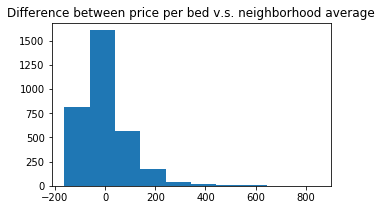

In [57]:
x = plt.hist(listings['price_per_bed_compared_to_nbh'])
plt.title('Difference between price per bed v.s. neighborhood average')

## 3.5 Add other numeric columns and id column (`id`)

In [58]:
final_df = final_df.join(listings[[
                                   'accommodates',
                                   'bathrooms',
                                   'bedrooms',
                                   'beds',
                                   'number_of_reviews',
                                   'review_scores_rating',
                                   'review_scores_accuracy',
                                   'review_scores_cleanliness',
                                   'review_scores_checkin',
                                   'review_scores_communication',
                                   'review_scores_location',
                                   'review_scores_value',
                                   'price_per_bed_compared_to_nbh'
                                   ]])

## 3.6 Deal with missing values

Columns with missing values:

In [59]:
m = final_df.isna().sum()
m[m>0]

downtown_bos                      143
east_bos                          143
reponse_rate                      471
acceptance_rate                   471
price                              12
accommodates                      339
bathrooms                         351
bedrooms                          349
beds                              343
number_of_reviews                 339
review_scores_rating             1058
review_scores_accuracy           1067
review_scores_cleanliness        1062
review_scores_checkin            1064
review_scores_communication      1062
review_scores_location           1066
review_scores_value              1065
price_per_bed_compared_to_nbh     355
dtype: int64

### 3.6.1 Columns that we want to set the NaN values as 0s

In [60]:
final_df[['downtown_bos',
            'east_bos',
            'price_per_bed_compared_to_nbh',
            'number_of_reviews']] = final_df[['downtown_bos',
                                                            'east_bos',
                                                            'price_per_bed_compared_to_nbh',
                                                            'number_of_reviews']].fillna(0)

### 3.6.2 Columns that need be filled with the means

In [61]:
final_df_sub1 = final_df[['reponse_rate',
                  'review_scores_rating',
                  'review_scores_accuracy',
                  'review_scores_cleanliness',
                  'review_scores_checkin',
                  'review_scores_communication',
                  'review_scores_location',
                  'review_scores_value']].copy()

final_df[['reponse_rate',
          'review_scores_rating',
          'review_scores_accuracy',
          'review_scores_cleanliness',
          'review_scores_checkin',
          'review_scores_communication',
          'review_scores_location',
          'review_scores_value']] = pd.DataFrame(Imputer(missing_values=float('nan'), 
                                                         strategy="mean", 
                                                         axis=0)\
                                                         .fit_transform(final_df_sub1),
                                                 columns = final_df_sub1.columns)

/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### 3.6.3 Columns that need be filled with the most common values

In [62]:
final_df_sub2 = final_df[['bathrooms','bedrooms','beds','acceptance_rate']].copy()

final_df[['bathrooms','bedrooms','beds','acceptance_rate']] = pd.DataFrame(Imputer(missing_values=float('nan'), 
                                                         strategy="most_frequent", 
                                                         axis=0)\
                                                         .fit_transform(final_df_sub2),
                                                         columns = final_df_sub2.columns)

/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### 3.6.4 Other missing values filling

In [63]:
final_df['accommodates'] = final_df['accommodates'].fillna(1)

Check the table again: 

In [64]:
m = final_df.isna().sum()
m[m>0]

price    12
dtype: int64

`price` is a very importance piece of information and we don't want to impute this value here. We will just drop the listings with `NaN` price.

In [65]:
final_df = final_df[final_df['price'] > 0]

## 3.7 Make sure all the columns except the id column are numeric

In [66]:
final_df.iloc[:,1:] = final_df.iloc[:,1:].astype("float32")

In [67]:
final_df.describe()

,id,downtown_bos,east_bos,host_age,reponse_rate,acceptance_rate,one_or_two_listings,three_to_ten_listings,more_than_ten_listings,response_time_ordinal,real_bed,amenities_len,cancellation_policy_ordinal,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,price,extra_people,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price_per_bed_compared_to_nbh
count,3.573000e+03,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.0,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000
mean,8.433550e+06,0.102155,0.008116,67.312996,0.949837,0.862107,0.589980,0.180800,0.225301,3.231458,0.963056,228.891129,2.210187,0.072768,0.084243,0.006717,0.053736,0.051777,0.030786,0.019871,0.075287,0.048139,0.041982,0.080325,0.008676,0.095998,0.001399,0.002519,0.006717,0.034705,0.040022,0.015673,0.040022,0.048419,0.022670,0.090960,0.013714,0.012874,0.113630,0.997761,0.727400,0.859502,0.0,0.165687,0.018752,0.066331,169.072769,10.908760,2.890568,1.213406,1.248531,1.566751,17.919954,91.860168,9.421767,9.270578,9.635466,9.636694,9.413442,9.154778,-0.000006
std,4.502261e+06,0.302896,0.089740,20.693491,0.116846,0.210115,0.491903,0.384903,0.417840,0.716080,0.188652,74.204720,0.876652,0.259791,0.277804,0.081697,0.225525,0.221610,0.172760,0.139583,0.263888,0.214091,0.200585,0.271826,0.092753,0.294630,0.037387,0.050131,0.081694,0.183059,0.196040,0.124219,0.196040,0.214681,0.148869,0.287589,0.116315,0.112746,0.317401,0.047272,0.445366,0.347555,0.0,0.371857,0.135664,0.248890,111.677078,19.149181,1.829529,0.495221,0.737968,0.997956,35.479752,7.957876,0.787944,0.964567,0.655241,0.631235,0.752137,0.853925,92.501076
min,3.353000e+03,0.000000,0.000000,37.466667,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,10.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,-162.673569
25%,4.653267e+06,0.000000,0.000000,52.266666,0.949891,0.780000,0.000000,

# 4. Calculate future earnings

We first check that all listings were scraped on the same day:

In [68]:
print(listings['calendar_last_scraped'].min())
print(listings['calendar_last_scraped'].max())

2016-09-06
2016-09-06


Another thing that we are concerning is that the availability data are probably much lower than what they actually will be, especially for the days that are in far future.

Text(0.5, 1.0, 'Vacancy rates with months')

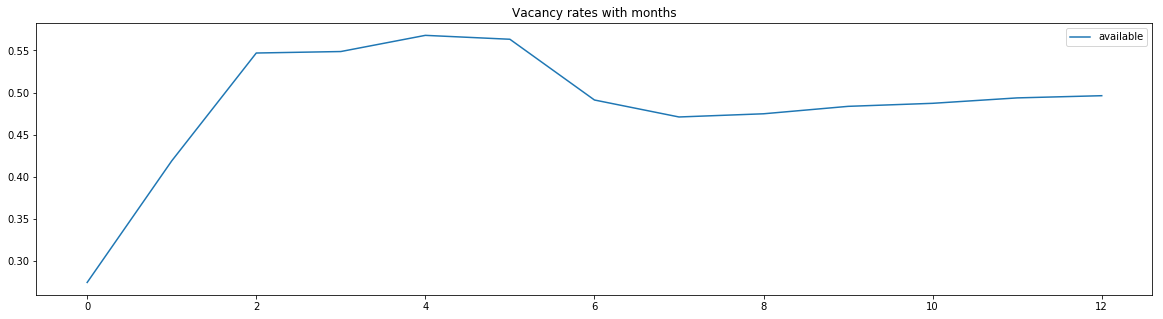

In [336]:
calendar['year_month'] = calendar['date'].apply(lambda x: x[:7])
calendar.groupby('year_month')['available'].mean().reset_index().plot()
plt.title('Vacancy rates with months')

The data was scraped on September 2016, and on that month about 27% of the listings are available, while in the next month 41% of rooms are available. However, for the next year until 2017 December, each month about half of the rooms are booked already. We believe that the future earnings we calculate out of the data are meaningful. Or if we have more historical, we might find out that usually when the month actually comes, the booking rate will rise by 20% (an example). In that way we can adjust our predicted results to approximate the real values.

According to my understanding, the `calendar` data shows the availablity of the listings for the following one year. When the room is not available, we won't have the price information. We know that the price for a listing is very seasonal and usually the price will increase a lot during busy seasons. Since we don't know the prices for the listings that were already booked, we will just use the price in the `listing` data to approximate that.

In [69]:
calendar = calendar.merge(listings[['id','price']].rename({'id':'listing_id'}, axis=1), on='listing_id')
calendar['available'] = calendar['available'].apply(convert_binary)
calendar['price_x'] = calendar['price_x'].apply(convert_money)
calendar['price_y'] = calendar['price_y'].apply(convert_money)
calendar_available = calendar[calendar['available']==1]
calendar_booked = calendar[calendar['available']==0]

Remember that in `calendar` data, if a room is available on a certain date, we can see its price on that day. We also have the price information in `listing` data. Thus we would like to compare the available prices in `calendar` data and those in `listing` data to see if the theoratical prices are very different from the prices in reality.

Text(0.5, 1.0, 'DIfference between prices in listings and actual prices')

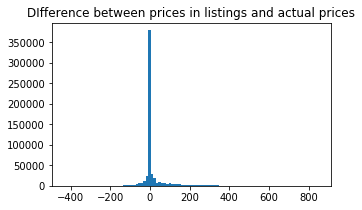

In [72]:
a = plt.hist(calendar_available['price_x'] - calendar_available['price_y'], bins=100)
plt.title("DIfference between prices in listings and actual prices")

Text(0.5, 1.0, 'Future Earnings')

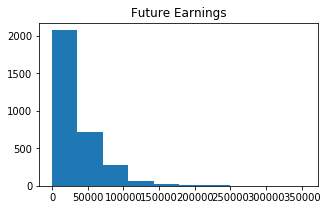

In [76]:
earnings = calendar_booked.groupby('listing_id')['price_y'].sum().reset_index().rename({'price_y':'future_earnings'}, axis=1)
a = plt.hist(earnings['future_earnings'])
plt.title("Future Earnings")

How many records have future earnings as 0?

In [77]:
sum(earnings['future_earnings'] == 0)

9

That's not a lot. The earnings data are very right skewed. We will do a log transformation on it:

In [78]:
earnings['log_future_earnings'] = np.log(earnings['future_earnings']+1)

In [79]:
def y_to_earnings(y):
    '''
    The function to convert the log earnings
    '''
    return np.exp(y)-1

Text(0.5, 1.0, 'Log Future Earnings')

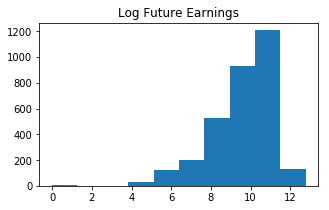

In [80]:
a = plt.hist(earnings['log_future_earnings'])
plt.title("Log Future Earnings")

# 5. Align the features table   

In [87]:
features = final_df.copy()
id_earnings = features[['id']].merge(earnings.rename({'listing_id':'id'}, axis=1).drop('future_earnings', axis=1), on="id", how="left").fillna(0)
print("{:.2%} of the listings don't have future earnings".format(sum(id_earnings['log_future_earnings']==0)/len(id_earnings)))

11.84% of the listings don't have future earnings


# 6. Split the dataset to testing and training sets

In [94]:
X_all = features.drop('id', axis=1)
y_all = id_earnings['log_future_earnings']
X_train, X_test, y_train, y_test = train_test_split(X_all,
                                                                  y_all,
                                                                  test_size = 0.2,
                                                                  random_state = 0)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 2858 samples.
Testing set has 715 samples.


# 7. Build the gradient boosting regressor 

In [123]:
def regressor(X, y, params, random_state=1):
    '''
    This function was borrowed from. https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py
    It takes the X, y and parameters of the model and plots how deviance change as we have more iterations and the important variables
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    
    # Fit regression model
    clf = GradientBoostingRegressor(**params)
    clf.fit(X_train, y_train)
    mse = mean_squared_error(y_test, clf.predict(X_test))
    print("MSE: %.4f" % mse)
    
    # Plot training deviance
    test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_predict(X_test)):
        test_score[i] = clf.loss_(y_test, y_pred)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')
    
    # Plot feature importance
    feature_importance = clf.feature_importances_
    
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    im = pd.DataFrame({'feature': features.columns[1:], 'relative importance': feature_importance}).sort_values('relative importance')[-20:]
    plt.subplot(1, 2, 2)
    plt.barh(im['feature'], im['relative importance'])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    plt.subplots_adjust(wspace=30)
    return clf, im

In [189]:
#the first trial
params = {
    'n_estimators': 200,
    'max_depth': 6,
    'min_samples_split': 2,
    'learning_rate': 0.01,
    'loss': 'ls',
}

Training set has 2000 samples.
Testing set has 858 samples.
MSE: 4.9733


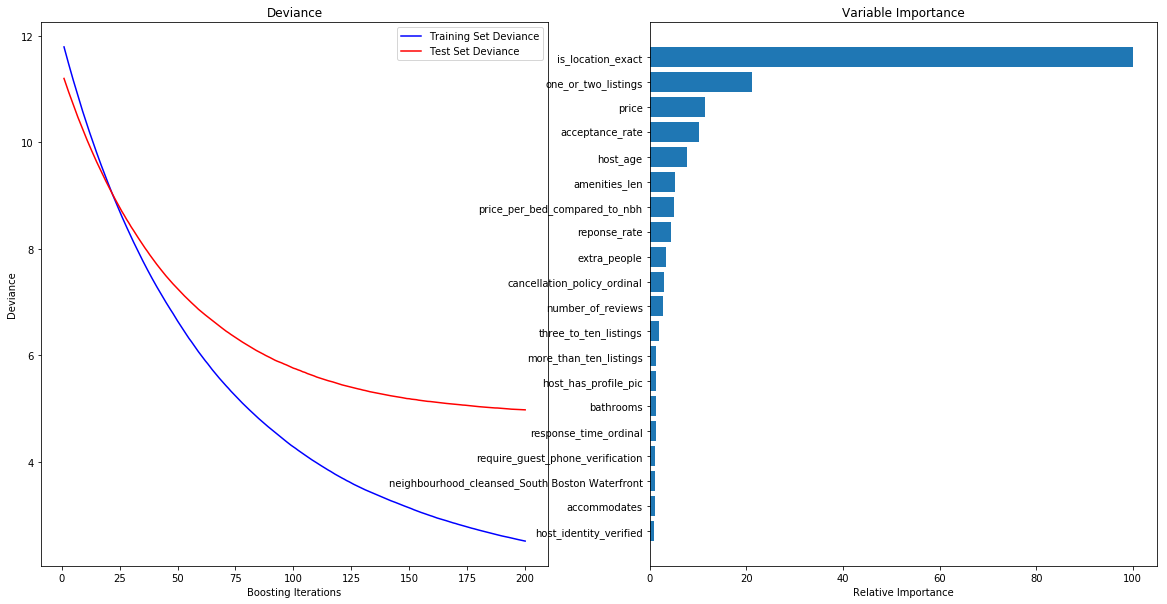

<Figure size 360x360 with 0 Axes>

In [190]:
model, im = regressor(X_train, 
                                y_train, 
                                params, random_state=1)

Our first model has a MSE of 5 --- which is about 8 dollars. The most important variable is `is_location_exact` --- we don't quite know what it means. The most important 9 features:

In [207]:
np.exp(5**0.5)-1

8.356469016601148

In [358]:
im.sort_values('relative importance', ascending=False)

,feature,relative importance
45,price,100.000000
2,host_age,55.482103
3,reponse_rate,26.924585
4,acceptance_rate,26.206234
5,one_or_two_listings,23.234339
46,extra_people,15.485575
10,amenities_len,14.712161
11,cancellation_policy_ordinal,12.177285
59,price_per_bed_compared_to_nbh,8.405304
8,response_time_ordinal,7.826637


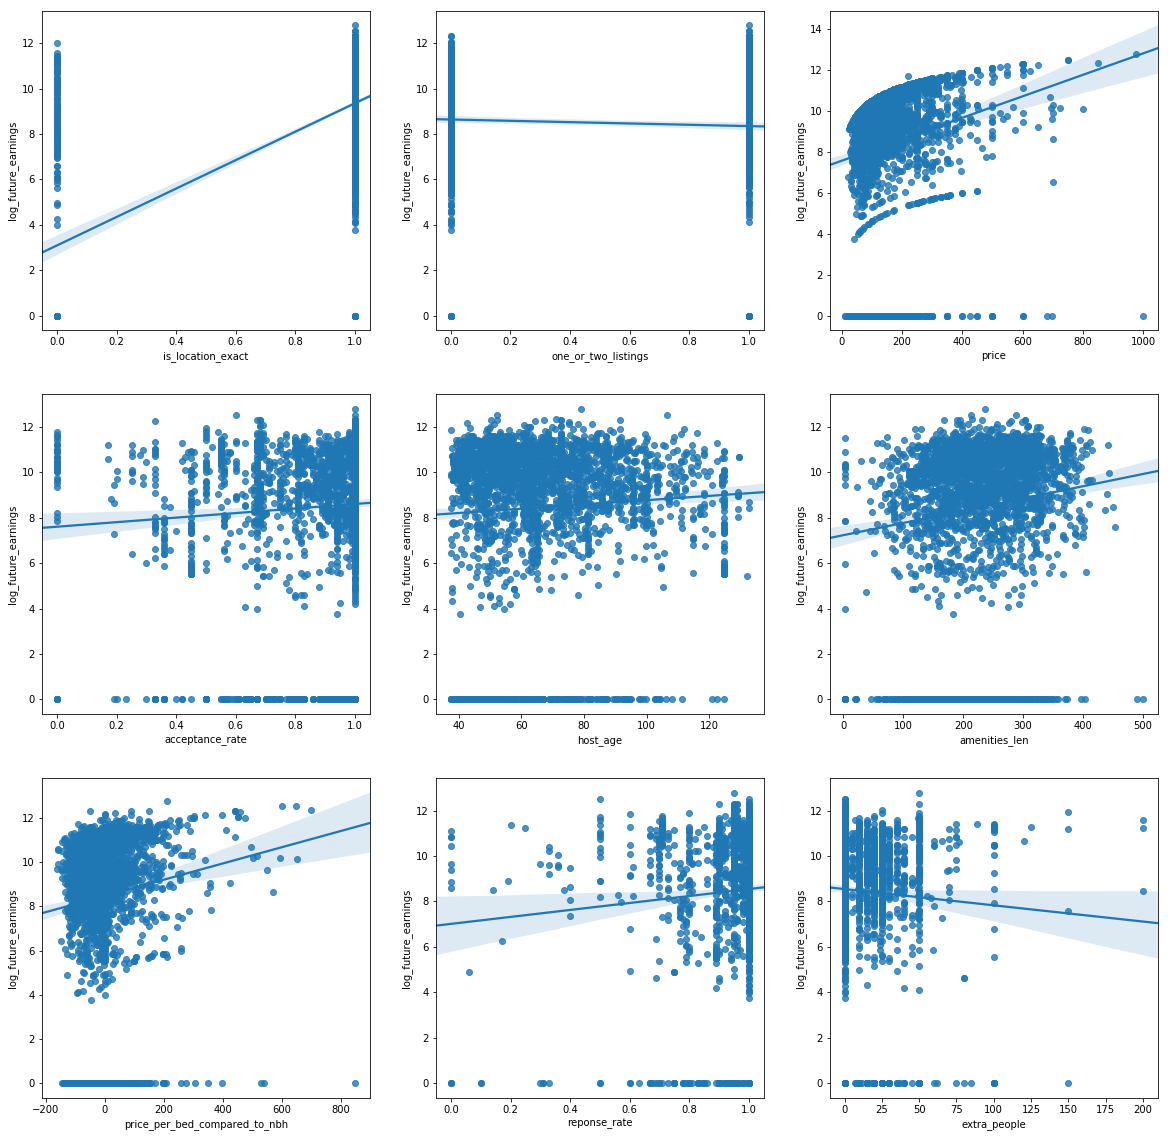

In [134]:
plt.rcParams['figure.figsize'] = (20,20)
for i in range(9):
    plt.subplot(3,3,i+1)
    sns.regplot(x=X_train[im.sort_values('relative importance', ascending=False)['feature'].values[i]], y=y_train)

Of course the future earnings are not determined by only one feature. From the scatter plot we can have an idea of whether a variable will positively or negatively affect the future earning.

We also see that 11% of the listings don't have future earnings. Are they very new listings? Are they of a certain kind?

In [146]:
no_earnings = id_earnings[id_earnings['log_future_earnings']==0].merge(features, on='id')
have_earnings = id_earnings[id_earnings['log_future_earnings']>0].merge(features, on='id')

Text(0.5, 1.0, 'price_have_earnings')

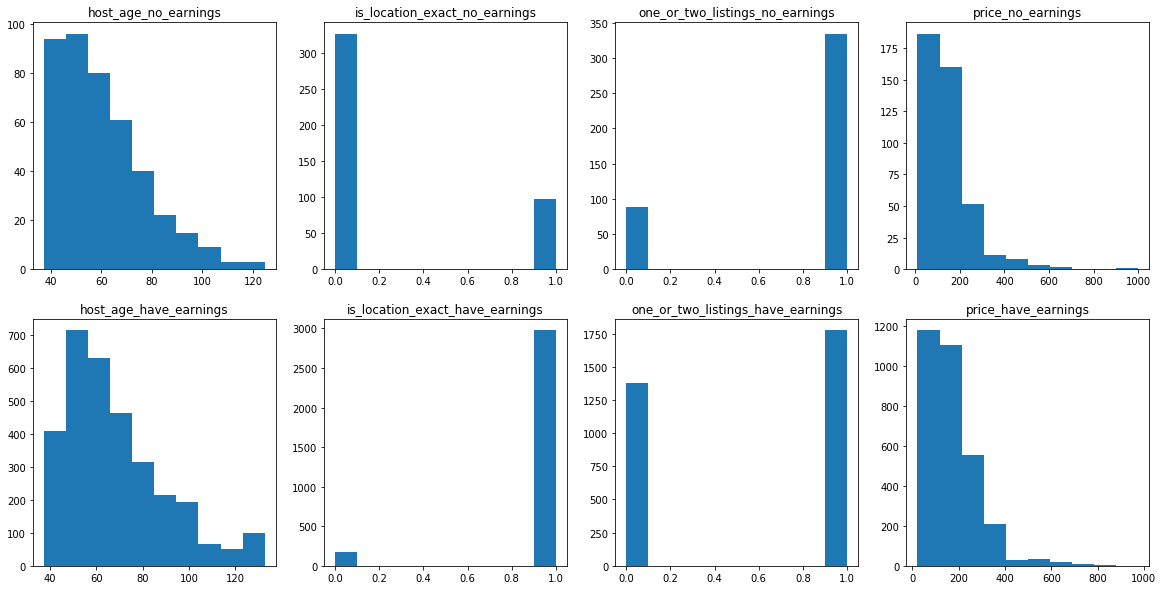

In [152]:
plt.rcParams['figure.figsize'] = (20,10)

plt.subplot(2,4,1)
a = plt.hist(no_earnings['host_age'])
plt.title("host_age_no_earnings")
plt.subplot(2,4,2)
a = plt.hist(no_earnings['is_location_exact'])
plt.title("is_location_exact_no_earnings")
plt.subplot(2,4,3)
a = plt.hist(no_earnings['one_or_two_listings'])
plt.title("one_or_two_listings_no_earnings")
plt.subplot(2,4,4)
a = plt.hist(no_earnings['price'])
plt.title("price_no_earnings")

plt.subplot(2,4,5)
a = plt.hist(have_earnings['host_age'])
plt.title("host_age_have_earnings")
plt.subplot(2,4,6)
a = plt.hist(have_earnings['is_location_exact'])
plt.title("is_location_exact_have_earnings")
plt.subplot(2,4,7)
a = plt.hist(have_earnings['one_or_two_listings'])
plt.title("one_or_two_listings_have_earnings")
plt.subplot(2,4,8)
a = plt.hist(have_earnings['price'])
plt.title("price_have_earnings")

We can see that listings with no earnings are mostly the listings with `is_location_exact` of 0. Are the no earning listings with `True` is_location_exact very new listings?

Text(0.5, 1.0, 'host_age of no earning listings with True is_location_exact')

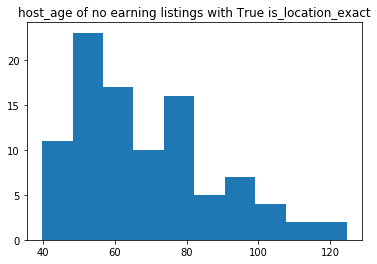

In [266]:
plt.rcParams['figure.figsize'] = (6,4)

a = plt.hist(no_earnings[no_earnings['is_location_exact']==1]['host_age'])
plt.title('host_age of no earning listings with True is_location_exact')

Didn't see that pattern here.

# 8. Tune the model

In [410]:
rg = GradientBoostingRegressor()
parameters = {'learning_rate': [0.01, 0.05, 0.08, 0.1],
                    'max_depth': [4, 6, 8, 10],
                    'max_features': [None, 50, 40, 30, 20, 15, 10]}
scorer = "neg_mean_squared_error"

In [411]:
grid_obj = GridSearchCV(rg, parameters, scoring=scorer)

In [412]:
grid_fit = grid_obj.fit(X_train, y_train)

/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


This is the best model!

In [413]:
best_model = grid_fit.best_estimator_
best_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=8, max_features=20,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [414]:
predicted_log_earnings = best_model.predict(X_test)
print("MSE of the tuned model: {:.3}".format(np.mean(np.square(predicted_log_earnings - y_test))))
difference = abs(y_to_earnings(predicted_log_earnings) - y_to_earnings(y_test))
print("{:.2%} have less than $1000 absolute error".format(sum(difference<1000)/len(y_test)))
print("{:.2%} have less than $5000 absolute error".format(sum(difference<5000)/len(y_test)))
print("{:.2%} have less than $10000 absolute error".format(sum(difference<10000)/len(y_test)))
print("{:.2%} have less than $20000 absolute error".format(sum(difference<20000)/len(y_test)))

MSE of the tuned model: 5.47
14.69% have less than $1000 absolute error
37.06% have less than $5000 absolute error
50.35% have less than $10000 absolute error
69.51% have less than $20000 absolute error


Text(0.5, 1.0, 'Absolute difference')

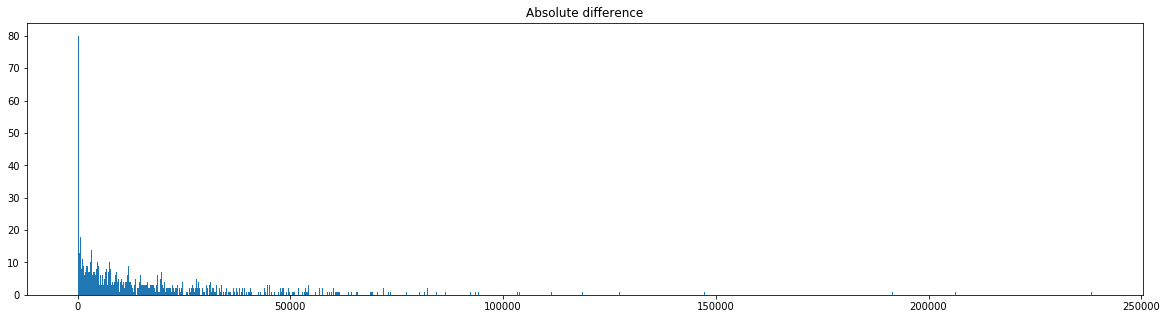

In [277]:
plt.rcParams['figure.figsize'] = (20,5)
a = plt.hist(difference, bins=1000)
plt.title('Absolute difference')

Text(0.5, 1.0, 'Earnings of listings with less than $1000 predicting error')

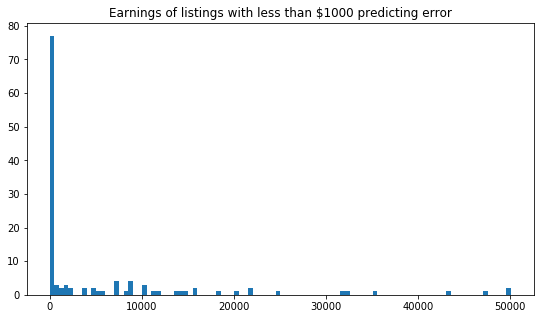

In [284]:
plt.rcParams['figure.figsize'] = (20,5)

plt.subplot(1,2,1)
plt.hist(y_to_earnings(y_test)[difference<1000], bins=100)
plt.title('Earnings of listings with less than $1000 predicting error')

Text(0.5, 1.0, 'actual earnings')

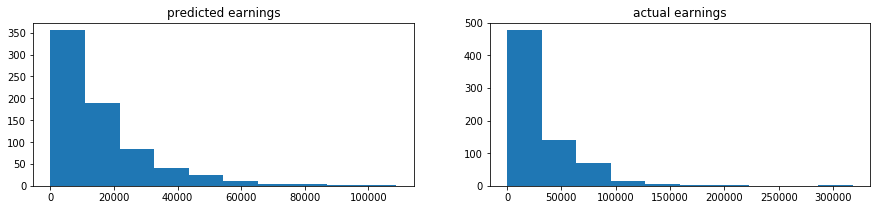

In [285]:
plt.rcParams['figure.figsize'] = (15,3)

plt.subplot(1,2,1)
a = plt.hist(y_to_earnings(predicted_log_earnings))
plt.title("predicted earnings")

plt.subplot(1,2,2)
a = plt.hist(y_to_earnings(y_test))
plt.title("actual earnings")

When tested on the test set, our model predicted half of the listings with less than $5000 absolute difference. From the histograms of the predicted earnings and actual earnings, we can see that our model is more conservative and produce smaller numbers for the listings that might have very high earnings.

Text(0, 0.5, 'predicted earnings')

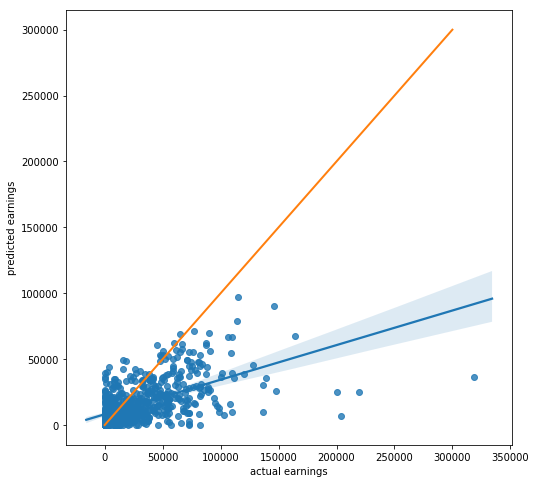

In [443]:
plt.rcParams['figure.figsize'] = (8, 8)
x = np.linspace(0,300000)
sns.regplot(x=y_to_earnings(y_test), y=y_to_earnings(predicted_log_earnings))
plt.plot(x, x, linewidth=2)
plt.xlabel("actual earnings")
plt.ylabel("predicted earnings")

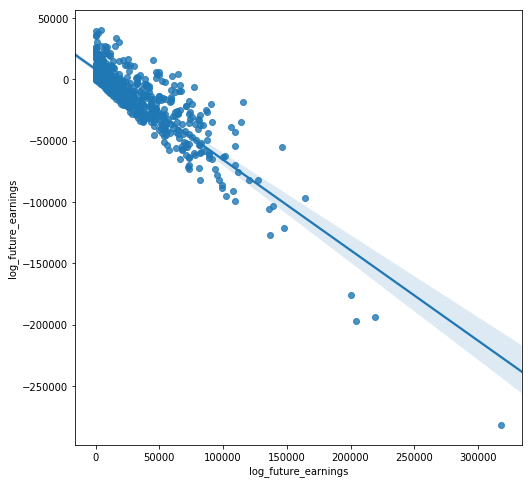

In [416]:
sns.regplot(x=y_to_earnings(y_test), y=y_to_earnings(predicted_log_earnings) - y_to_earnings(y_test))

# 9. What if we leave out listings with no future earnings when training the model? 

11% of the listings don't have future earnings --- they are not booked at all for the next year at the time when the data was scraped. Most of them have `Is_location_exact` as 0. They might be outliers. Let's train the model again only with the listings that have future earnings.

In [359]:
def prepare_train_test_data(X_all, y_all, test_size=0.2):
    '''
    Split the data into traning set and testing set
    '''
    X_train, X_test, y_train, y_test = train_test_split(X_all,
                                                                      y_all,
                                                                      test_size = 0.2,
                                                                      random_state = 0)
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    return X_train, X_test, y_train, y_test

def tune_train_model(rg, parameters, scorer, X_train, y_train):
    '''
    Grid search on parameters to find the best model
    '''
    grid_obj = GridSearchCV(rg, parameters, scoring=scorer)
    grid_fit = grid_obj.fit(X_train, y_train)
    best_model = grid_fit.best_estimator_
    return best_model

def evaluate_model(best_model, X_test, y_test):
    '''
    Fit the model on testing set; calculate the MSE; calculate percentages of the records with less than X amount of absolute error
    '''
    predicted_log_earnings = best_model.predict(X_test)
    print("MSE of the tuned model: {:.3}".format(np.mean(np.square(predicted_log_earnings - y_test))))
    difference = abs(y_to_earnings(predicted_log_earnings) - y_to_earnings(y_test))
    print("{:.2%} have less than $1000 absolute error".format(sum(difference<1000)/len(y_test)))
    print("{:.2%} have less than $5000 absolute error".format(sum(difference<5000)/len(y_test)))
    print("{:.2%} have less than $10000 absolute error".format(sum(difference<10000)/len(y_test)))
    print("{:.2%} have less than $20000 absolute error".format(sum(difference<20000)/len(y_test)))
    return predicted_log_earnings, predicted_log_earnings, difference

In [360]:
parameters1 = {'learning_rate': [0.01, 0.05, 0.08, 0.1],
                    'max_depth': [4, 6, 8, 10],
                    'max_features': [None, 50]}

In [389]:
have_future_earnings_index = id_earnings['log_future_earnings'] > 0
X_train_new, X_test_new, y_train_new, y_test_new = prepare_train_test_data(X_all[have_future_earnings_index.values], y_all[have_future_earnings_index.values])
best_model = tune_train_model(rg, parameters, scorer, X_train_new, y_train_new)

Training set has 2520 samples.
Testing set has 630 samples.


/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [390]:
best_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=10, max_features=10,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [396]:
predicted_log_earnings, difference = evaluate_model(best_model, X_test_new, y_test_new)

MSE of the tuned model: 1.18
8.25% have less than $1000 absolute error
31.59% have less than $5000 absolute error
50.16% have less than $10000 absolute error
70.79% have less than $20000 absolute error


The MSE is much smaller and apparently, this new model performs much better.

Text(0.5, 1.0, 'Absolute difference')

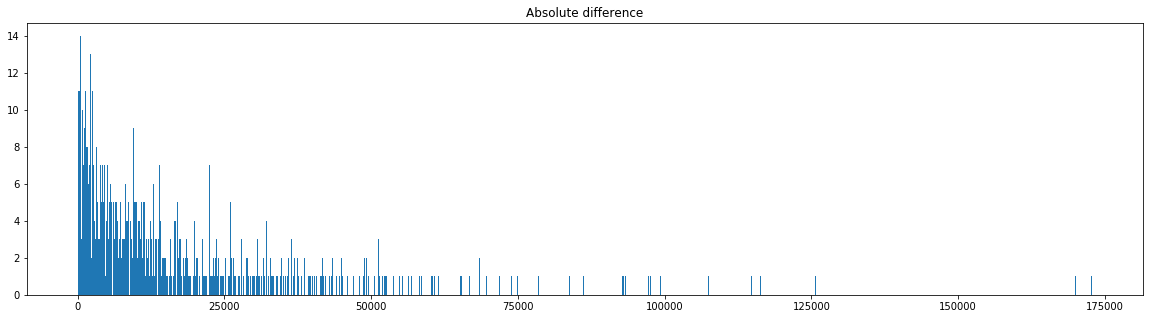

In [397]:
plt.rcParams['figure.figsize'] = (20,5)
a = plt.hist(difference, bins=1000)
plt.title('Absolute difference')

Text(0, 0.5, 'actual earnings')

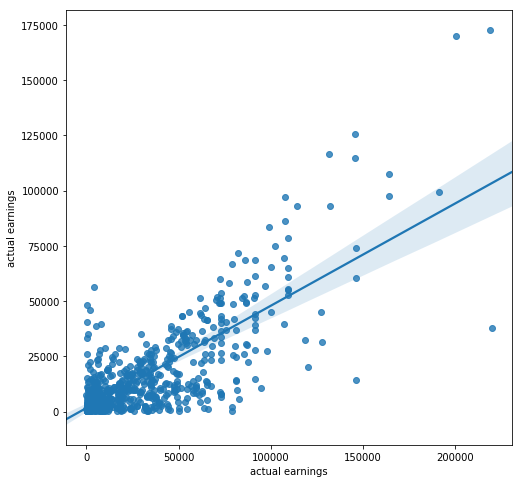

In [399]:
plt.rcParams['figure.figsize'] = (8, 8)
sns.regplot(x=y_to_earnings(y_test_new), y=difference)
plt.xlabel("actual earnings")
plt.ylabel("actual earnings")

We can see that there are quite a few listings that actually don't have any future earnings but were predicted to have earnings by the model. We are then curious --- what if we only train and test the model on the listings where `Is_location_exact` is 1 and have future earnings.

In [400]:
new_index = (id_earnings['log_future_earnings'] > 0) & (X_all.reset_index().drop("index", axis=1)['is_location_exact'] == 1)
X_train_new, X_test_new, y_train_new, y_test_new = prepare_train_test_data(X_all.reset_index().drop("index", axis=1)[new_index.values], y_all[new_index.values])
best_model = tune_train_model(rg, parameters, scorer, X_train_new, y_train_new)

Training set has 2379 samples.
Testing set has 595 samples.


/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [404]:
best_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=10, max_features=15,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [405]:
predicted_log_earnings, difference = evaluate_model(best_model, X_test_new, y_test_new)

MSE of the tuned model: 1.32
10.76% have less than $1000 absolute error
32.77% have less than $5000 absolute error
50.42% have less than $10000 absolute error
72.77% have less than $20000 absolute error


Text(0, 0.5, 'difference')

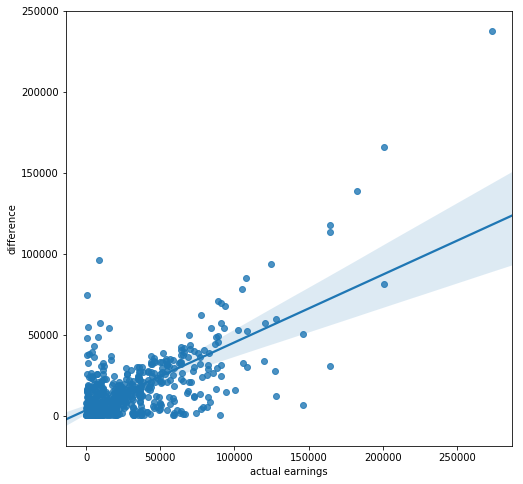

In [409]:
plt.rcParams['figure.figsize'] = (8, 8)
sns.regplot(x=y_to_earnings(y_test_new), y=difference)
plt.xlabel("actual earnings")
plt.ylabel("difference")

The model performs slightly better.

# 10. Interesting take-aways 

From the model we can see that it's important to have `Is_location_exact` as 1 (although we are not quite sure what it means). Price and `Price_per_bed_compared_to_neighborhood` have positive effect on the future earnings but I think it's mostly because listings with higher price have better amenities, locations, etc. So don't worry if your listing is more expensive than most of the other listings in the neighbordhood. If your room is truly in better condition and provides more exciting stuffs for the guests, you will have better future earnings. The length of the amenity field also has a positive effect. Other important factors are acceptance rate and response rate.

To improve the model, I think it will help to get more enrichment on the address data. For example, we can get the house price data using the addresses. We can also have a look how many hotels there are in the neighborhood of the listing. 